# Sentiment-Driven Stock Trading with Reinforcement Learning

This notebook demonstrates how to train and test a reinforcement learning agent for stock trading that incorporates news sentiment. We use the Proximal Policy Optimization (PPO) algorithm from Stable Baselines 3 to train our agent on historical stock price and sentiment data.

The agent learns to make trading decisions (buy, hold, or sell) based on:
- Historical price patterns (OHLCV data)
- News sentiment analysis
- Account state (balance, holdings)

We then evaluate the model's performance on test data and compare it to a simple buy-and-hold strategy.

## Setup

First, we'll import the necessary libraries and set up our environment.

In [1]:
import sys
sys.path.append('..')
import config

In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from envs.trading_env import TradingEnv
from scripts.generic import evaluate_model, plot_one_instance,plot_networths_profit,load_test_model_env

In [3]:
import torch
print(torch.cuda.is_available())  # Should now print True

True


chose the model and policy

In [4]:
# from stable_baselines3 import PPO as MODEL
# POLICY = 'MlpPolicy'

from sb3_contrib import RecurrentPPO as MODEL 
POLICY = 'MlpLstmPolicy'

## Environment Creation

We'll use a custom Gymnasium environment that simulates stock trading with the following features:
- Continuous action space for nuanced trading decisions
- Observation space including OHLCV data, sentiment, and account information
- Transaction cost consideration
- Support for separate train/test data splits

In [5]:
ticker = config.SINGLE_STOCK
env = TradingEnv(
    tickers=ticker,  # or your single stock
    window_size=20,
    transaction_cost=0.01,
    stability_penalty_weight=0.15,
    sentiment_influence=0.4,
    mode='train',
    train_start_date=config.TRAIN_START_DATE,
    train_end_date=config.TRAIN_END_DATE,
    test_start_date=config.TEST_START_DATE,
    test_end_date=config.TEST_END_DATE,
)
env = DummyVecEnv([lambda: env])
# can normalize
# env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

Data split complete for 1 stocks
Data aligned to 250 common trading days


## Model Training

Now we'll train a Proximal Policy Optimization (PPO) agent using our environment.
The agent will learn to make trading decisions to maximize returns while considering:
- Price trends
- Sentiment signals
- Transaction costs
- Portfolio balance

The model will be saved to disk after training for later use.

In [34]:
# Create and train the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MODEL(POLICY, env, tensorboard_log="../logs",device=device, verbose=1
              ,learning_rate=0.0001)

model.learn(total_timesteps=20000)
# Save the model
model_path = f"../models/{MODEL.__name__}_{ticker}.zip"
model.save(model_path)
env.envs[0].save(f"../models/env_ppo_{ticker}.pkl")  

Using cuda device
Logging to ../logs\RecurrentPPO_31
----------------------------
| time/              |     |
|    fps             | 155 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 128 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 79           |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 256          |
| train/                  |              |
|    approx_kl            | 0.0005445662 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | -6.6         |
|    learning_rate        | 0.0001       |
|    loss                 | 0.0386       |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00458     |
|    std                  | 1            |
|    value_lo

## Model Evaluation

Let's evaluate our trained model on the test dataset.
We'll run the model on unseen data and track:
- Portfolio net worth over time
- Trading actions taken
- Cumulative rewards

Data split complete for 1 stocks
Data aligned to 400 common trading days
Data aligned to 251 common trading days
Environment set to test mode with 251 data points


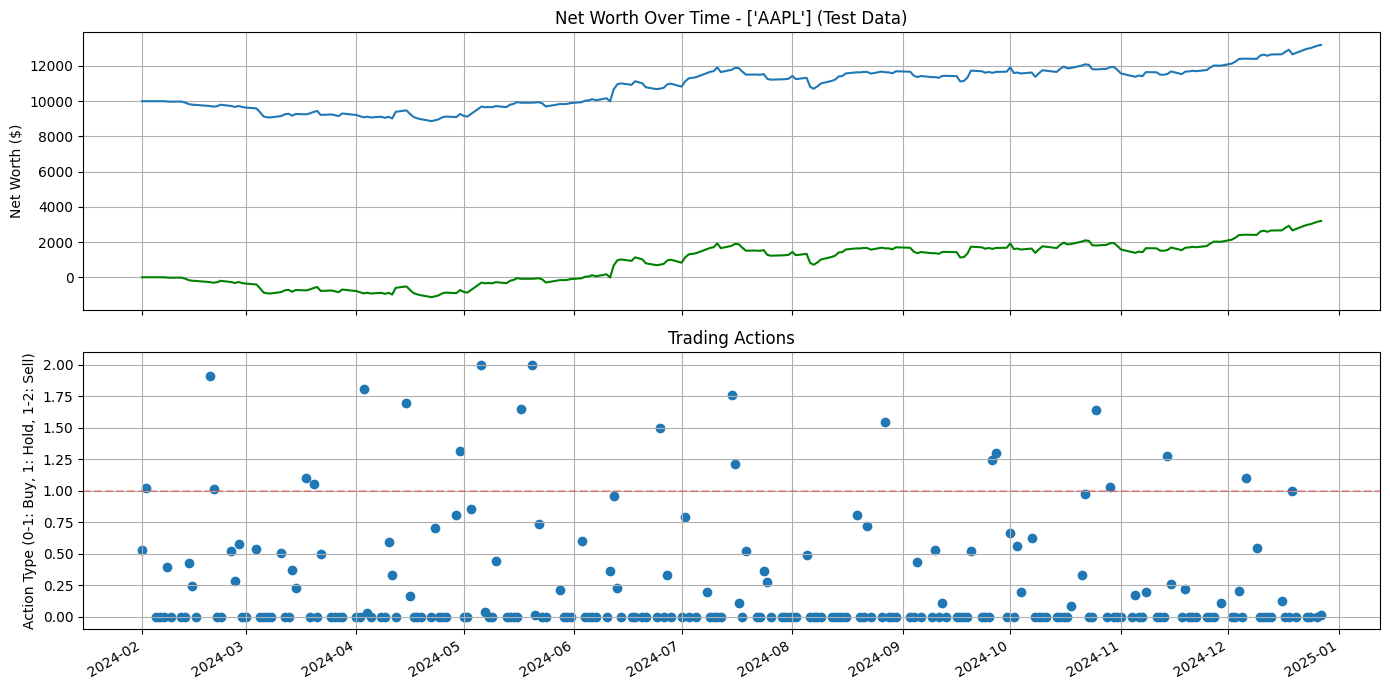

In [33]:
# Load saved environment and set to test 
test_env_path = f"../models/env_ppo_{ticker}.pkl"
model_path = f"../models/{MODEL.__name__}_{ticker}.zip"
model, test_env = load_test_model_env(MODEL, POLICY, test_env_path, model_path)

# Evaluate the model
net_worths, rewards, actions, dates = evaluate_model(model, test_env)

if net_worths[-1] == config.INITIAL_BALANCE:
    net_worths.pop(-1)
    actions.pop(-1)
    dates.pop(-1)
    rewards.pop(-1)
    
# Convert dates to proper datetime objects for plotting
dates = pd.to_datetime(dates)

# Plot net worth over time with dates
plot_one_instance(net_worths=net_worths, actions=actions, dates=dates, ticker=ticker)

### Performance Analysis

Finally, let's analyze the performance of our model and compare it to a simple buy-and-hold strategy.
Metrics include:
- Total return percentage
- Maximum drawdown
- Comparison with buy-and-hold returns

In [8]:
# Analyze model performance
final_return = ((net_worths[-1] - config.INITIAL_BALANCE) / config.INITIAL_BALANCE) * 100 
max_drawdown = ((np.maximum.accumulate(net_worths) - net_worths) / np.maximum.accumulate(net_worths)).max() * 100

print(f"Final Return: {final_return:.2f}%")
print(f"Max Drawdown: {max_drawdown:.2f}%")

# Compare with buy and hold strategy
test_start_date = dates[0]
test_end_date = dates[-1]
print(f"Test period: {test_start_date.strftime('%Y-%m-%d')} to {test_end_date.strftime('%Y-%m-%d')}")

# Get the first and last close prices from the test data
# Since test_env is DummyVecEnv, we need to get the underlying env first
base_env = test_env.envs[0]
first_price = base_env.test_data[ticker[0]].iloc[0]['Close']
last_price = base_env.test_data[ticker[0]].iloc[-1]['Close']
buy_hold_return = (last_price - first_price) / first_price * 100

print(f"Buy & Hold Return: {buy_hold_return:.2f}%")
print(f"RL Model vs Buy & Hold: {final_return - buy_hold_return:.2f}%")

# Display mode information
print(f"Training mode had {len(base_env.train_data[ticker[0]])} data points")
print(f"Testing mode had {len(base_env.test_data[ticker[0]])} data points")


Final Return: 26.72%
Max Drawdown: 11.07%
Test period: 2024-02-01 to 2024-12-27
Buy & Hold Return: 36.52%
RL Model vs Buy & Hold: -9.80%
Training mode had 250 data points
Testing mode had 251 data points


# Evaluation & Plots over multiple episode

In [24]:
# --- Evaluate with 100 episodes ---
test_env_path = f"../models/env_ppo_{ticker}.pkl"
model_path = f"../models/{MODEL.__name__}_{ticker}.zip"
model, test_env = load_test_model_env(MODEL, POLICY, test_env_path, model_path)

net_worths_array = []
# evaluate the model over 100 episodes
episodes = 100
for episode in range(1, episodes + 1):
    net_worths , _r, _a, _d = evaluate_model(model, test_env)
    del _r , _a , _d
    if net_worths[-1] == config.INITIAL_BALANCE:
        net_worths.pop(-1)
    net_worths_array.append(net_worths[-1])
    if episode % 5 == 0:
        print(f"episode:\t{episode}/{episodes}\tAvg Net worth:\t{np.mean(net_worths):.2f}\tFinal Net worth:\t{net_worths[-1]:.2f}")
    if episode == episodes:
        print("Evalution finished")
        print(f"Avg Net Worth: {np.mean(net_worths_array):.2f}")

# save the results
results = {
    'net_worths': net_worths_array
}
results_df = pd.DataFrame(results)
results_df.to_csv(f"../results/{MODEL.__name__}_{ticker}_{episodes}_results.csv", index=False)    

Data split complete for 1 stocks
Data aligned to 400 common trading days
Data aligned to 251 common trading days
Environment set to test mode with 251 data points
episode:	5/100	Avg Net worth:	10413.74	Final Net worth:	11982.49
episode:	10/100	Avg Net worth:	10532.69	Final Net worth:	12233.80
episode:	15/100	Avg Net worth:	10988.97	Final Net worth:	13382.29
episode:	20/100	Avg Net worth:	10701.67	Final Net worth:	12961.20
episode:	25/100	Avg Net worth:	11172.11	Final Net worth:	13724.65
episode:	30/100	Avg Net worth:	11040.88	Final Net worth:	13487.90
episode:	35/100	Avg Net worth:	10281.95	Final Net worth:	11928.06
episode:	40/100	Avg Net worth:	10570.84	Final Net worth:	12597.83
episode:	45/100	Avg Net worth:	10470.24	Final Net worth:	12527.15
episode:	50/100	Avg Net worth:	10558.90	Final Net worth:	12567.08
episode:	55/100	Avg Net worth:	10755.98	Final Net worth:	12845.29
episode:	60/100	Avg Net worth:	11013.46	Final Net worth:	12919.06
episode:	65/100	Avg Net worth:	10725.04	Final 

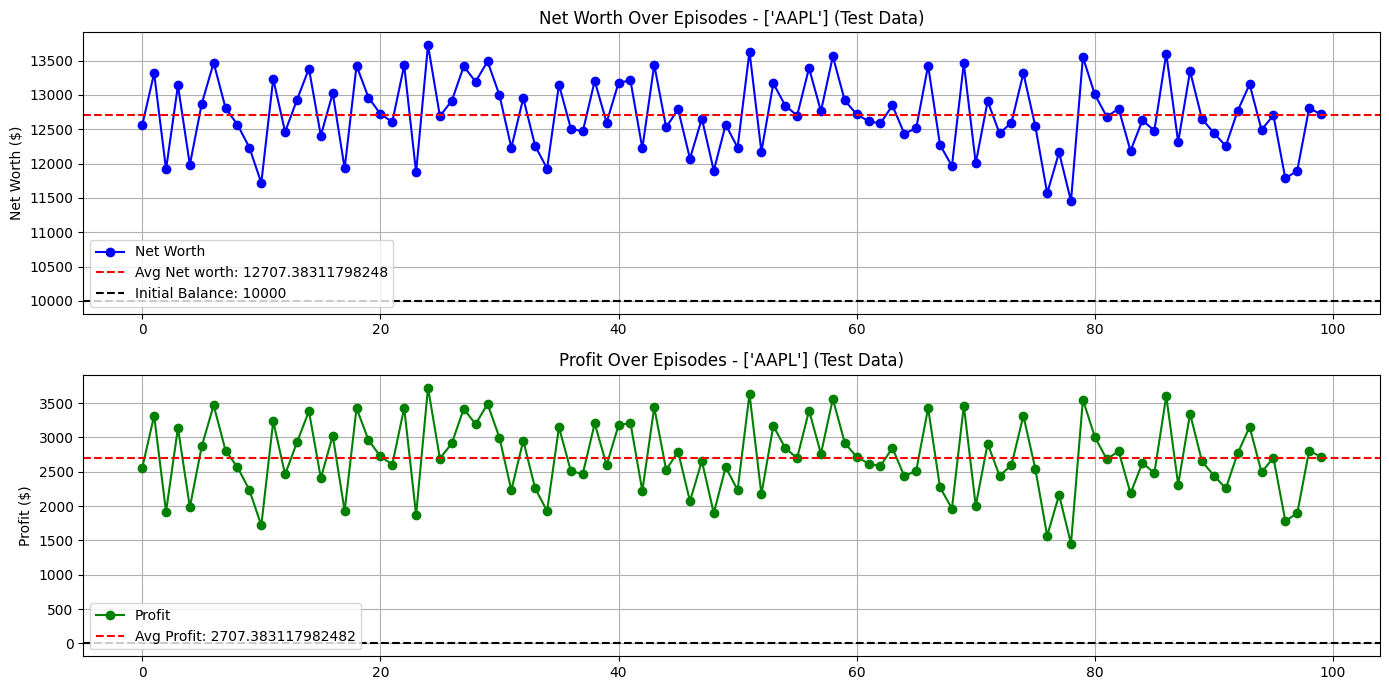

Maximum Net Worth:	13724.65	Maximum Profit: 3724.65
Minimum Net Worth:	11454.17	Minimum Profit: 1454.17


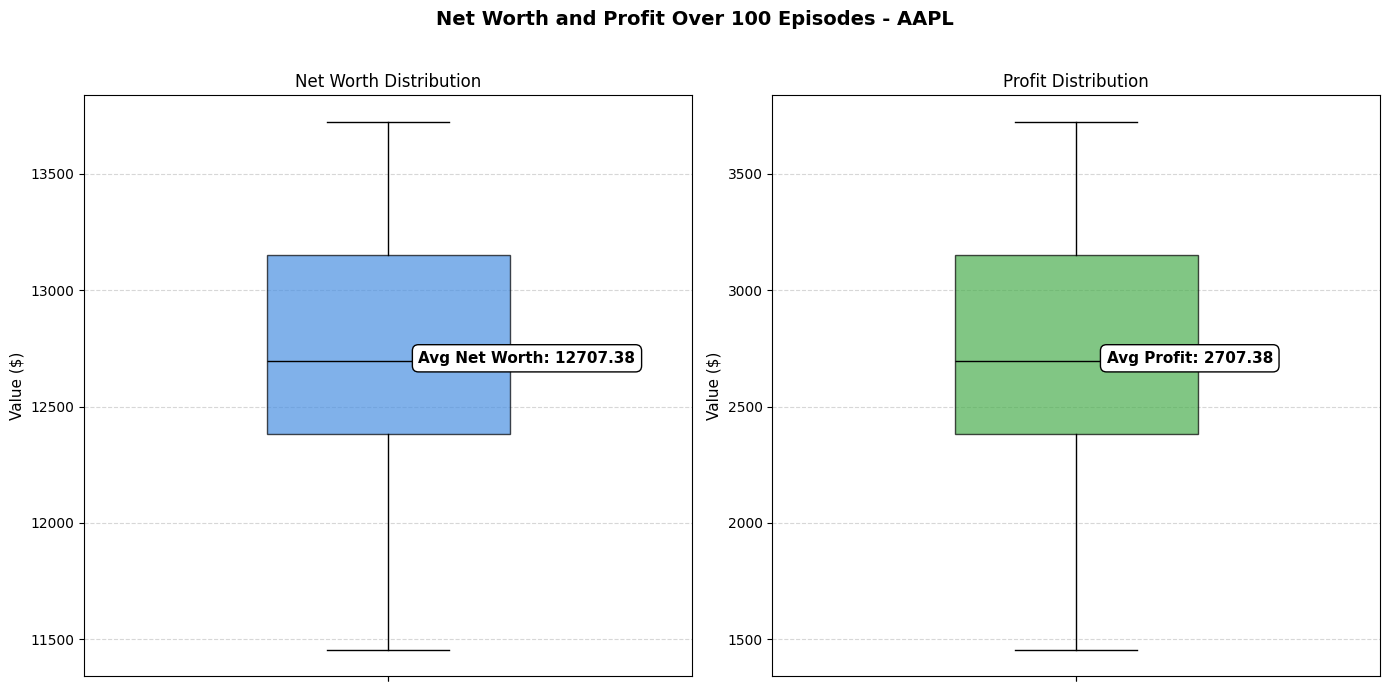

In [13]:
episodes = 100
# load the results
results_df = pd.read_csv(f"../results/{MODEL.__name__}_{ticker}_{episodes}_results.csv")
# Extract each column as a array
net_worths = np.array(results_df['net_worths'].values)
profit = np.array(net_worths) - np.array([config.INITIAL_BALANCE]*len(net_worths)) 
# Net Worth and Profit Over Episodes With Sentiment Analysis
plot_networths_profit(net_worths, profit, ticker)